In [1]:
import rerun as rr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
%matplotlib inline

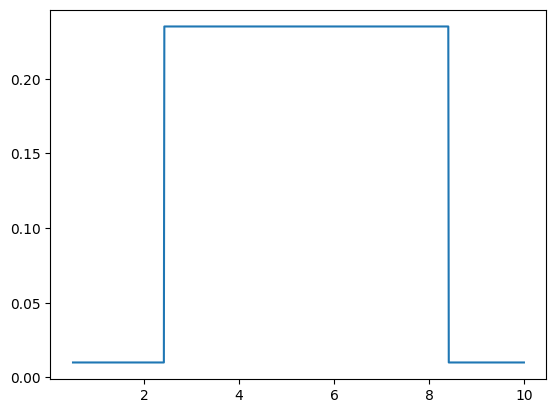

In [2]:

path_to_rrd = "./step_response.rrd"
recording = rr.dataframe.load_recording(path_to_rrd)
batches = recording.view(index="sample_time", contents="/**").select()
df: pd.DataFrame = batches.read_pandas()

Fs = 100
df = df[df['sample_time'] > pd.to_timedelta(0.5*1e9)]
df = df[df['sample_time'] < pd.to_timedelta(10*1e9)]
ts = df['sample_time'].to_numpy().astype(np.float64) / 1e9
velocity = np.concatenate(df['/velocity:Scalar'].to_numpy())
control = np.concatenate(df['/control:Scalar'].to_numpy()) - 3/200
plt.plot(ts, control)

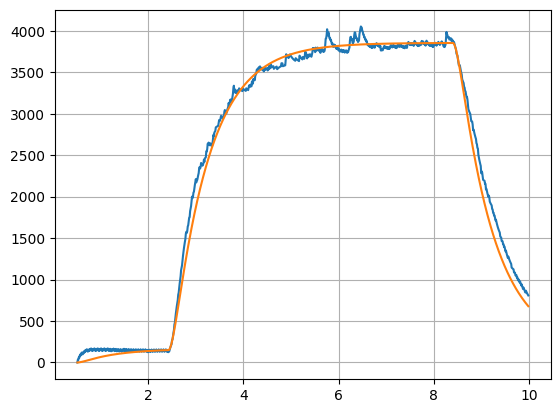

In [3]:
# static gain: 2050 / 0.125
# Time constant = 0.56
K = 2050/0.125
T = 0.75
model = ct.tf([K], [T, 1])
modeld = ct.c2d(model, Ts=1/Fs)


def apply_filter(A, B, C, signal):
    assert A.shape[0] == A.shape[1]
    x0 = np.zeros((A.shape[0], 1))

    out = np.zeros_like(signal)
    for i in range(len(signal)):
        x0 = A@x0 + B@signal[i:i+1,:]
        out[i:i+1,:] = C@x0
    return out

lpfilter = ct.tf([1], [0.1, 1])
lpfilterd = ct.c2d(lpfilter, Ts=1/Fs)
velocity_n1 = velocity.reshape((1,-1))
_, out = ct.forced_response(lpfilterd, ts, velocity_n1)
plt.plot(ts, out)

ss = ct.tf2ss(modeld*lpfilterd)
signal = control.reshape((-1,1))
out = apply_filter(ss.A, ss.B, ss.C, signal)
plt.plot(ts, out)
plt.grid(visible=True)


In [ ]:
Ts = 0.05
ss = ct.tf2ss(ct.c2d(model,Ts=Ts))
print(ss.A)
print(ss.B)
ticks_to_rad = 2*3.14159/200
print(ss.C * ticks_to_rad)


[[0.93550699]]
[[1.]]
[[66.45628037]]


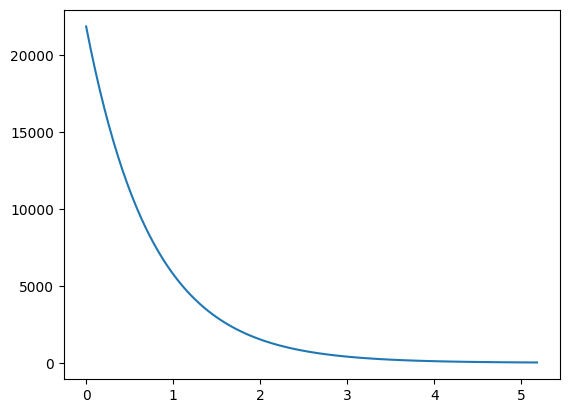

In [26]:

accel = ct.tf([K, 0], [T, 1])
ts, yout = ct.step_response(accel)
plt.plot(ts, yout)


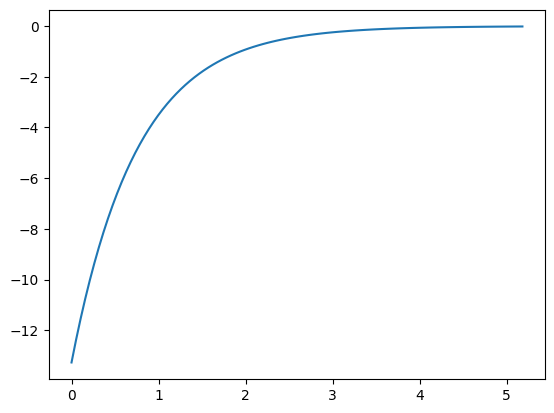

In [ ]:

Iflywheel = 277.4

est_m = 0.134
mstang = 0.38
Istang = 268.95 * mstang/est_m
rcg = 45.7

mwheel = 0.063
mmotor = 0.113

rout = 150 # mm

Ieverything = rcg**2*mstang + Istang + (mwheel*mmotor)*rout**2 + Iflywheel

rotratio = Iflywheel/Ieverything

ts, yout = ct.step_response(-accel*rotratio * 2*3.14159/360 * 0.25)
plt.plot(ts, yout)
